# **Casos confirmados de COVID-19 en Bogotá D.C.**

**Exploratory Data Analysis Project by Carlos Alberto Cortés Ramírez**

Permite conocer la evolución del número de casos confirmados con nuevo coronavirus COVID-19 en el contexto de la pandemia.

Secretaría Distrital de Salud.

https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c/resource/b64ba3c4-9e41-41b8-b3fd-2da21d627558

# **Importando Datos**

Se intentó importar datos vía API, sin embargo se detectaron varios errores en la documentación y los links solo daban de a 100 registros, lo cual hace la tarea muy ineficiente. Por lo cual se hará descargando el archivo .csv. De manera anecdotica se deja como sería sacar los datos desde la API




```python
url = 'https://datosabiertos.bogota.gov.co/api/3/action/datastore_search?resource_id=b64ba3c4-9e41-41b8-b3fd-2da21d627558'  
fileobj = urllib.request.urlopen(url)
data = fileobj.read().decode('utf-8')
parsed_data = json.loads(data)
df = pd.DataFrame(parsed_data["result"]["records"])
next_records = parsed_data["result"]["_links"]["next"]

urllib.request.urlopen('https://datosabiertos.bogota.gov.co'+next_records)
```



# Metadatos provistos por la alcaldía

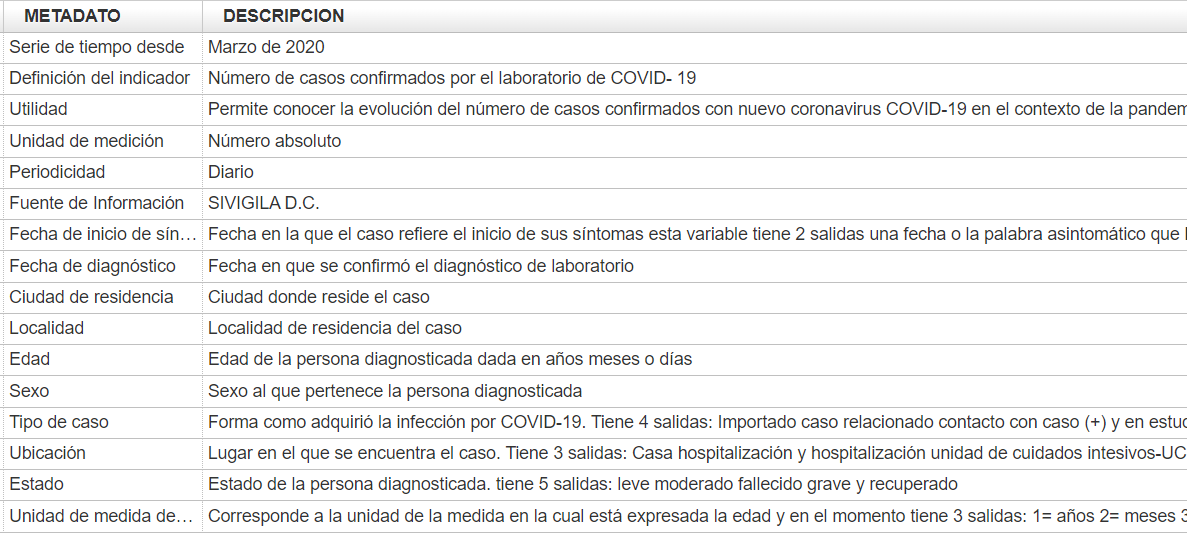

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import scipy.stats as ss
import geopandas as gpd

Familiarizandose con la Data

In [3]:

df = pd.read_csv('osb_enftransm-covid-19_20230329.csv', encoding = 'utf-8',  sep=',')

# There is a error trying to import the data in a default way
# ParserError: Error tokenizing data. C error: Expected 1 fields in line 845266, saw 3
# the default separator

In [4]:
df.head()

,CASO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-02-26,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-04,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-07,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-06,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-06,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


In [5]:
df.shape

(1876297, 11)

In [6]:
df.columns

Index(['CASO', 'FECHA_DE_INICIO_DE_SINTOMAS', 'FECHA_DIAGNOSTICO', 'CIUDAD',
       'LOCALIDAD_ASIS', 'EDAD', 'UNI_MED', 'SEXO',
       'FUENTE_O_TIPO_DE_CONTAGIO', 'UBICACION', 'ESTADO'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876297 entries, 0 to 1876296
Data columns (total 11 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   CASO                         int64 
 1   FECHA_DE_INICIO_DE_SINTOMAS  object
 2   FECHA_DIAGNOSTICO            object
 3   CIUDAD                       object
 4   LOCALIDAD_ASIS               object
 5   EDAD                         int64 
 6   UNI_MED                      int64 
 7   SEXO                         object
 8   FUENTE_O_TIPO_DE_CONTAGIO    object
 9   UBICACION                    object
 10  ESTADO                       object
dtypes: int64(3), object(8)
memory usage: 157.5+ MB


In [8]:
df.describe()

,CASO,EDAD,UNI_MED
count,1.876297e+06,1.876297e+06,1.876297e+06
mean,9.381490e+05,3.920477e+01,1.005343e+00
std,5.416404e+05,1.821313e+01,7.754102e-02
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.690750e+05,2.600000e+01,1.000000e+00
50%,9.381490e+05,3.700000e+01,1.000000e+00
75%,1.407223e+06,5.200000e+01,1.000000e+00
max,1.876297e+06,1.190000e+02,3.000000e+00


# **Data Cleaning**

En cuanto a la columna de UNI_MED se nos menciona que esta indica la unidad de medida en la que se encuentra la edad, 1 para años, 2 para meses y 3 para días. Para practicidad de este EDA, vamos a pasar todos las edades a años y posteriormente descartar la columna UNI_MED.

El maximo número de meses es **27**, por lo tanto estaremos cambiando edades entre 0,1 y 2 años para UNI_MED = 2

In [9]:
df[df['UNI_MED']==2]['EDAD'].unique()

array([10,  8,  2,  9,  6,  7,  5, 11,  1,  3,  4, 16, 12, 14, 17, 28, 20,
       29, 22, 27, 21], dtype=int64)

In [10]:
def change_age(x):
    if x < 12:
        return 0
    elif x < 24:
        return 1
    else: 
        return 2
    
df.loc[df['UNI_MED']==2,'EDAD'] = df[df['UNI_MED']==2]['EDAD'].map(lambda x: change_age(x))

In [11]:
df[df['UNI_MED']==2]['EDAD'].unique()

array([0, 1, 2], dtype=int64)

El maximo número de días es **51**, por lo tanto estaremos cambiando edades de solo 0 años para UNI_MED = 1

In [12]:
df.loc[df['UNI_MED']==3,'EDAD'].unique()

array([26, 13, 28, 23,  4,  6, 25, 27,  8, 19,  1, 29, 14,  5, 22, 20,  3,
       15, 17,  2, 10, 18, 24, 16, 21, 11,  7,  9, 12, 51, 31],
      dtype=int64)

In [13]:
df.loc[df['UNI_MED']==3,'EDAD'] = 0

In [14]:
df[df['UNI_MED']==3]['EDAD'].unique()

array([0], dtype=int64)

In [15]:
df.drop(columns=['UNI_MED'],axis=0,inplace=True)

In [16]:
df[df.columns]

,CASO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-02-26,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado
1,2,2020-03-04,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado
2,3,2020-03-07,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado
3,4,2020-03-06,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado
4,5,2020-03-06,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado
...,...,...,...,...,...,...,...,...,...,...
1876292,1876293,NaN,2023-03-25,Sin dato,Sin dato,34,F,Comunitaria,Casa,Leve
1876293,1876294,NaN,2023-03-25,Sin dato,Sin dato,58,F,Comunitaria,Casa,Leve
1876294,1876295,NaN,2023-03-25,Sin dato,Sin dato,82,F,Comunitaria,Casa,Leve
1876295,1876296,NaN,2023-03-25,Sin dato,Sin dato,58,F,Comunitaria,Casa,Leve


In [17]:
df.isna().sum(axis=0)/len(df)

CASO                           0.000000
FECHA_DE_INICIO_DE_SINTOMAS    0.254578
FECHA_DIAGNOSTICO              0.000000
CIUDAD                         0.000000
LOCALIDAD_ASIS                 0.000000
EDAD                           0.000000
SEXO                           0.000000
FUENTE_O_TIPO_DE_CONTAGIO      0.000000
UBICACION                      0.000000
ESTADO                         0.000000
dtype: float64

**Descartando columna de fecha de inicio de sintomas**

Esta columna tiene mas de un 25% de datos faltantes, además no se considera muy relevante para el analisis, por lo cual se decide descartar

In [18]:
df = df.drop('FECHA_DE_INICIO_DE_SINTOMAS',axis=1)

In [19]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado


# Outliers

Detectando valores de edades muy altos usando un percentil del 99.9%, los muy bajos no los vamos a tener en cuenta puesto hay mucha más población recién nacida que personas que pasen de 90 - 95 años

In [20]:
upper_limit = df['EDAD'].quantile(0.999)
upper_limit

94.0

In [21]:
df[df['EDAD']>upper_limit]

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
573,574,2020-04-03,Bogotá,Antonio Nariño,95,F,Relacionado,Casa,Recuperado
725,726,2020-04-04,Bogotá,Kennedy,97,F,Relacionado,Fallecido,Fallecido
1242,1243,2020-04-09,Bogotá,Teusaquillo,97,F,Relacionado,Fallecido,Fallecido
1569,1570,2020-04-18,Bogotá,Suba,103,F,En estudio,Fallecido,Fallecido
2200,2201,2020-04-25,Bogotá,Puente Aranda,95,M,En estudio,Fallecido,Fallecido
...,...,...,...,...,...,...,...,...,...
1875028,1875029,2023-02-24,Sin dato,Sin dato,96,M,Comunitaria,Casa,Recuperado
1875416,1875417,2023-03-02,Sin dato,Sin dato,95,F,Comunitaria,Casa,Recuperado
1875421,1875422,2023-03-03,Sin dato,Sin dato,97,M,Comunitaria,Casa,Recuperado
1875547,1875548,2023-03-08,Bogotá,Engativá,95,F,Comunitaria,Hospital,Moderado


**Con Distribución "Normal"**

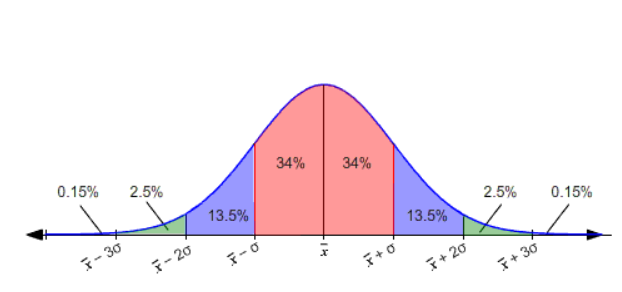

Ahora descartaremos los outliers con 3 desviaciones estandar alejado de la media, puesto que dada una distribución normal, el 99.7% de los datos se encontran en un rango de 3 distribuciones normales

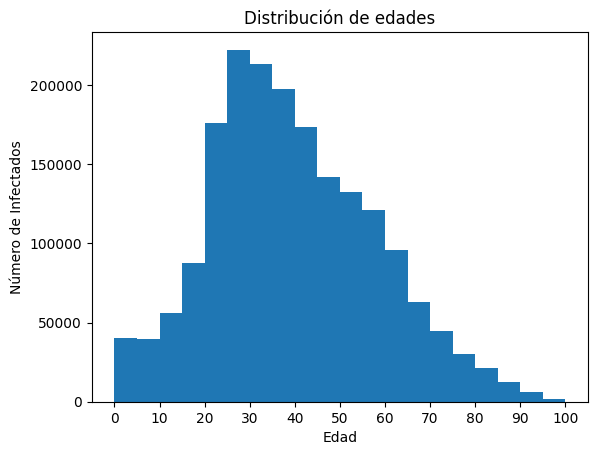

In [22]:
bins = np.arange(0,105, 5)
bins
fig, ax = plt.subplots()
ax.hist(df['EDAD'], bins=bins)

# set the x and y axis tick marks
ax.set_xticks(np.arange(0,105, 10))

ax.set_xlabel('Edad')
ax.set_ylabel('Número de Infectados')
ax.set_title('Distribución de edades')

plt.show()

In [23]:
mean = df['EDAD'].mean()
mean

39.17350931115916

In [24]:
std = df['EDAD'].std()
std

18.272030070574193

In [25]:
upper_limit = mean+3*std
upper_limit

93.98959952288175

In [26]:
df[df['EDAD']>upper_limit]

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
573,574,2020-04-03,Bogotá,Antonio Nariño,95,F,Relacionado,Casa,Recuperado
725,726,2020-04-04,Bogotá,Kennedy,97,F,Relacionado,Fallecido,Fallecido
1242,1243,2020-04-09,Bogotá,Teusaquillo,97,F,Relacionado,Fallecido,Fallecido
1569,1570,2020-04-18,Bogotá,Suba,103,F,En estudio,Fallecido,Fallecido
2200,2201,2020-04-25,Bogotá,Puente Aranda,95,M,En estudio,Fallecido,Fallecido
...,...,...,...,...,...,...,...,...,...
1875473,1875474,2023-03-07,Bogotá,Suba,94,F,Comunitaria,Casa,Recuperado
1875547,1875548,2023-03-08,Bogotá,Engativá,95,F,Comunitaria,Hospital,Moderado
1875701,1875702,2023-03-06,Sin dato,Sin dato,94,F,Comunitaria,Hospital,Moderado
1875751,1875752,2023-03-18,Sin dato,Sin dato,96,M,Comunitaria,Casa,Recuperado


In [27]:
df = df[df['EDAD']<upper_limit]

# **Data Exploration**

**plt.hist description**

This method uses numpy.histogram to bin the data in **x** and **count the number of values in each bin, then draws the distribution** either as a BarContainer or Polygon. The bins, range, density, and weights parameters are forwarded to numpy.histogram.

In [28]:
bins = np.arange(0,105, 5)
bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

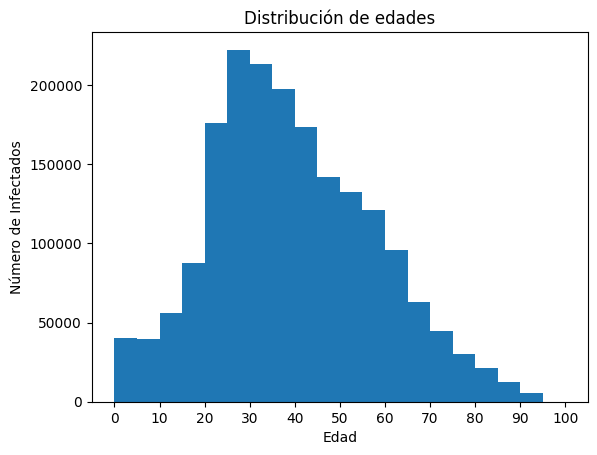

In [29]:
fig, ax = plt.subplots()
ax.hist(df['EDAD'], bins=bins)

# set the x and y axis tick marks
ax.set_xticks(np.arange(0,105, 10))

ax.set_xlabel('Edad')
ax.set_ylabel('Número de Infectados')
ax.set_title('Distribución de edades')

plt.show()

# **Mapa de Bogotá**

<Axes: >

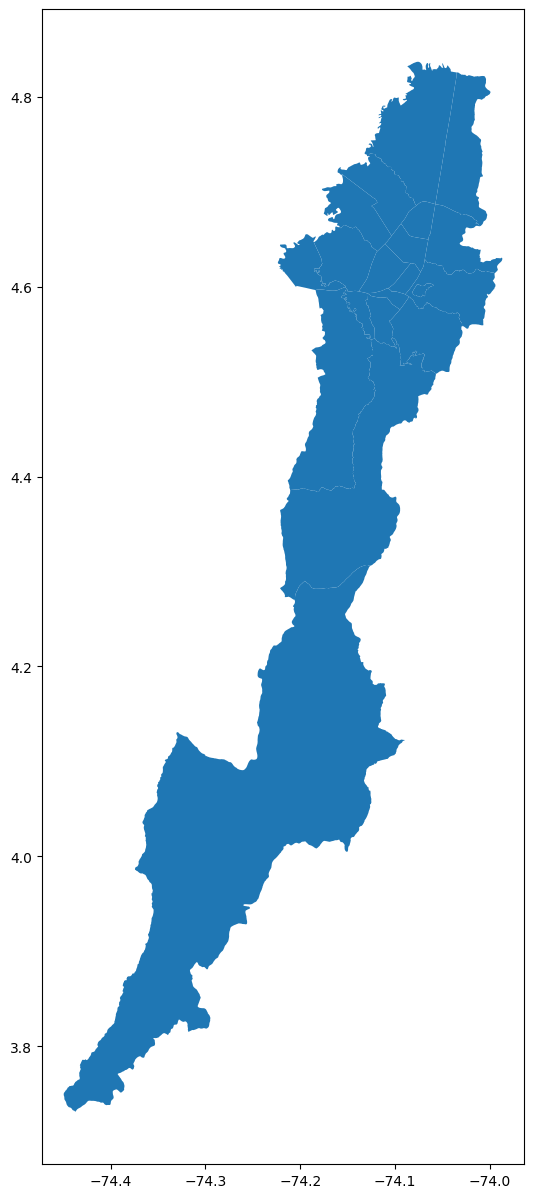

In [30]:
# Crea un objeto GeoDataFrame de GeoPandas
bog_map = gpd.read_file('poligonos-localidades.geojson')
bog_map.plot(figsize=(30,15))

In [31]:
bog_map.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry
0,ANTONIO NARIÑO,Acuerdo 117 de 2003,"4879543,386426",15,"{'lon': -74.10284240061449, 'lat': 4.588770674...","MULTIPOLYGON (((-74.13075 4.59335, -74.13075 4..."
1,TEUSAQUILLO,Acuerdo 8 de 1977,"14193168,127546",13,"{'lon': -74.08576901958143, 'lat': 4.641173586...","MULTIPOLYGON (((-74.09372 4.66607, -74.10342 4..."
2,SUMAPAZ,Acuerdo 9 de 1986,"780968757,719072",20,"{'lon': -74.25697871800469, 'lat': 4.036568747...","MULTIPOLYGON (((-74.20584 4.26966, -74.20567 4..."
3,SAN CRISTOBAL,Acuerdo 117 de 2003,"49098548,52917",04,"{'lon': -74.06607256050648, 'lat': 4.548749008...","MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4..."
4,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4..."


In [32]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado


# Transformar columna localidad
Debemos pasarlo a mayusculas y quitarle las tildes para que coincida con la del mapa

**Descartar Sumapaz**

Como sumapaz cuenta con tan pocos casos se decide descartarla del conteo, aproximadamente contaba con 152 comparada con cientos de miles en las otras localidades

In [33]:
bog_map = bog_map[bog_map['Nombre de la localidad'] != 'SUMAPAZ']

In [34]:
df_localidades = df.groupby('LOCALIDAD_ASIS').count()
df_localidades

,CASO,FECHA_DIAGNOSTICO,CIUDAD,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
LOCALIDAD_ASIS,,,,,,,,
Antonio Nariño,24134,24134,24134,24134,24134,24134,24134,24134
Barrios Unidos,43485,43485,43485,43485,43485,43485,43485,43485
Bosa,125097,125097,125097,125097,125097,125097,125097,125097
Chapinero,63148,63148,63148,63148,63148,63148,63148,63148
Ciudad Bolívar,101080,101080,101080,101080,101080,101080,101080,101080
Engativá,204939,204939,204939,204939,204939,204939,204939,204939
Fontibón,97491,97491,97491,97491,97491,97491,97491,97491
Fuera de Bogotá,31982,31982,31982,31982,31982,31982,31982,31982
Kennedy,224864,224864,224864,224864,224864,224864,224864,224864


In [35]:
import unicodedata
# Función generada por chatGPT para omitir tildes
def quitar_tildes(texto):
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = texto_normalizado.encode('ASCII', 'ignore').decode('utf-8')
    return texto_sin_tildes

In [36]:
df_localidades.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
LOCALIDAD_ASIS,,,,,,,,
Antonio Nariño,24134,24134,24134,24134,24134,24134,24134,24134
Barrios Unidos,43485,43485,43485,43485,43485,43485,43485,43485
Bosa,125097,125097,125097,125097,125097,125097,125097,125097
Chapinero,63148,63148,63148,63148,63148,63148,63148,63148
Ciudad Bolívar,101080,101080,101080,101080,101080,101080,101080,101080


In [37]:
df_localidades.index.map(lambda x:quitar_tildes(x.upper()))

Index(['ANTONIO NARINO', 'BARRIOS UNIDOS', 'BOSA', 'CHAPINERO',
       'CIUDAD BOLIVAR', 'ENGATIVA', 'FONTIBON', 'FUERA DE BOGOTA', 'KENNEDY',
       'LA CANDELARIA', 'LOS MARTIRES', 'PUENTE ARANDA', 'RAFAEL URIBE URIBE',
       'SAN CRISTOBAL', 'SANTA FE', 'SIN DATO', 'SUBA', 'SUMAPAZ',
       'TEUSAQUILLO', 'TUNJUELITO', 'USAQUEN', 'USME'],
      dtype='object', name='LOCALIDAD_ASIS')

In [38]:
df_localidades.index = df_localidades.index.map(lambda x:quitar_tildes(x.upper()))
df_localidades = df_localidades['CASO'] # nos podemos quedar con solo una columna porque hicimos un .count por lo tanto todas las columnas tendran el mismo valor
df_localidades

LOCALIDAD_ASIS
ANTONIO NARINO         24134
BARRIOS UNIDOS         43485
BOSA                  125097
CHAPINERO              63148
CIUDAD BOLIVAR        101080
ENGATIVA              204939
FONTIBON               97491
FUERA DE BOGOTA        31982
KENNEDY               224864
LA CANDELARIA          10249
LOS MARTIRES           23801
PUENTE ARANDA          67856
RAFAEL URIBE URIBE     81145
SAN CRISTOBAL          70005
SANTA FE               32815
SIN DATO               64687
SUBA                  290168
SUMAPAZ                  151
TEUSAQUILLO            54665
TUNJUELITO             38690
USAQUEN               164565
USME                   58768
Name: CASO, dtype: int64

In [39]:
casos_por_localidad = bog_map.merge(df_localidades, left_on='Nombre de la localidad',right_on='LOCALIDAD_ASIS')
casos_por_localidad.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry,CASO
0,TEUSAQUILLO,Acuerdo 8 de 1977,"14193168,127546",13,"{'lon': -74.08576901958143, 'lat': 4.641173586...","MULTIPOLYGON (((-74.09372 4.66607, -74.10342 4...",54665
1,SAN CRISTOBAL,Acuerdo 117 de 2003,"49098548,52917",04,"{'lon': -74.06607256050648, 'lat': 4.548749008...","MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4...",70005
2,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4...",164565
3,TUNJUELITO,Acuerdo 117 de 2003,"9910939,743524",06,"{'lon': -74.13598945142014, 'lat': 4.574841398...","MULTIPOLYGON (((-74.13777 4.59489, -74.14043 4...",38690
4,BOSA,Acuerdo 14 de 1983,"23933196,086856",07,"{'lon': -74.19438893446508, 'lat': 4.621779959...","MULTIPOLYGON (((-74.18567 4.64705, -74.18568 4...",125097


In [40]:
casos_por_localidad  = casos_por_localidad.sort_values(by ='CASO',ascending=False)
casos_por_localidad.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry,CASO
12,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4...",290168
14,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4...",224864
9,ENGATIVA,Acuerdo 8 de 1977,"35880967,349154",10,"{'lon': -74.113187703298, 'lat': 4.70112556327...","MULTIPOLYGON (((-74.15547 4.71798, -74.15547 4...",204939
2,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4...",164565
4,BOSA,Acuerdo 14 de 1983,"23933196,086856",07,"{'lon': -74.19438893446508, 'lat': 4.621779959...","MULTIPOLYGON (((-74.18567 4.64705, -74.18568 4...",125097


<Axes: title={'center': 'Distribución Casos COVID-19 por localidades'}>

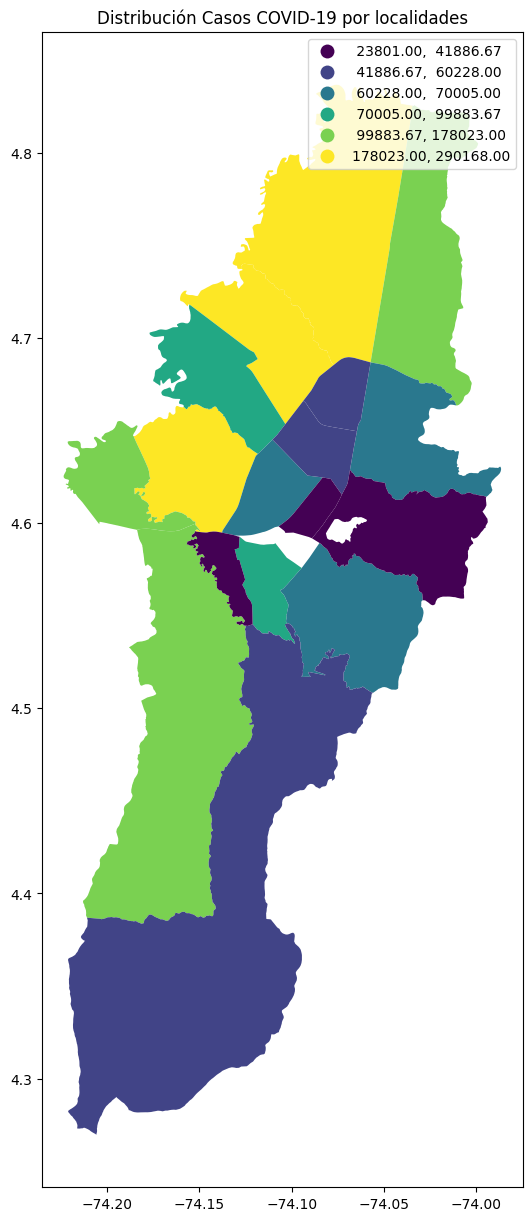

In [41]:
ax = casos_por_localidad.plot(column='CASO', scheme='QUANTILES',k=6,legend=True,figsize=(30,15))
ax.set_title('Distribución Casos COVID-19 por localidades')
ax

# Diagrama de Barras 

In [42]:
mask = (df_localidades.index != 'SUMAPAZ') & (df_localidades.index != 'SIN DATO') & (df_localidades.index != 'FUERA DE BOGOTA')
df_localidades = df_localidades[mask]

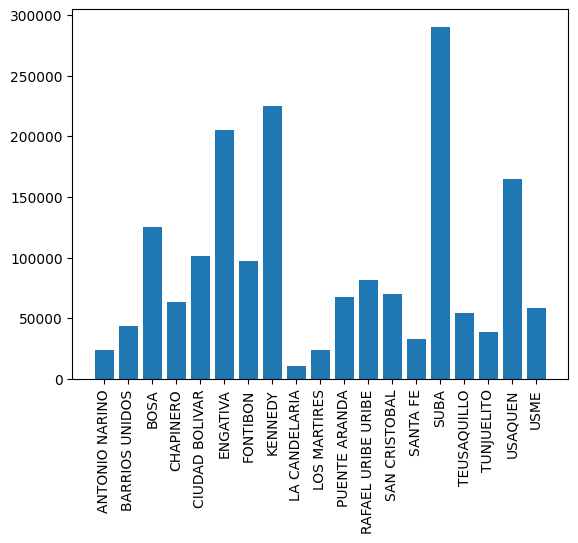

In [43]:
plt.bar(df_localidades.index,df_localidades)
plt.xticks(rotation=90)
plt.show()

# Casos con el tiempo

In [44]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado


In [45]:
df_by_date = df.groupby('FECHA_DIAGNOSTICO').agg(["count"])

In [46]:
df_by_date.head()

,CASO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
,count,count,count,count,count,count,count,count
FECHA_DIAGNOSTICO,,,,,,,,
2020-03-06,1,1,1,1,1,1,1,1
2020-03-10,2,2,2,2,2,2,2,2
2020-03-12,2,2,2,2,2,2,2,2
2020-03-13,6,6,6,6,6,6,6,6
2020-03-14,4,4,4,4,4,4,4,4


**Pasar columna fecha a tipo fecha**

In [47]:
from datetime import datetime
df_by_date.index = df_by_date.index.map(lambda x:datetime.strptime(x, '%Y-%m-%d') )

# Graficar

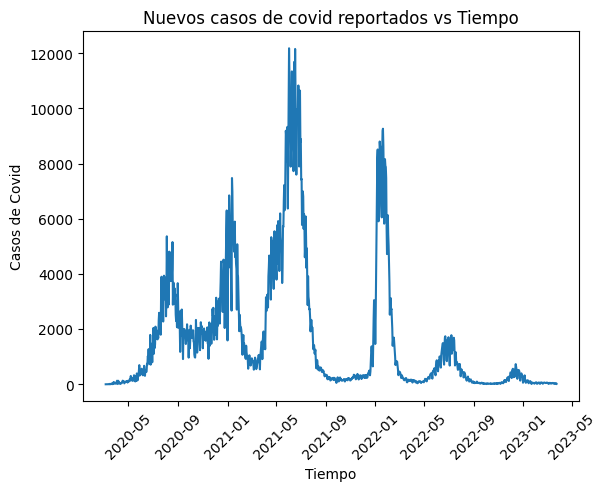

In [48]:
fig, ax = plt.subplots()
plt.xlabel('Tiempo')
plt.ylabel('Casos de Covid')
plt.title('Nuevos casos de covid reportados vs Tiempo')
plt.xticks(rotation=45)
plt.plot(df_by_date.index,df_by_date['CASO'])
#plt.bar(df_by_date.index,df_by_date['CASO'])
plt.show()

# Graficas variables cualitativas

Vamos a explorar las variables cualitativas con distintas graficas que nos permitan entender los fenomenos del COVID en Bogotá

**Sexo**

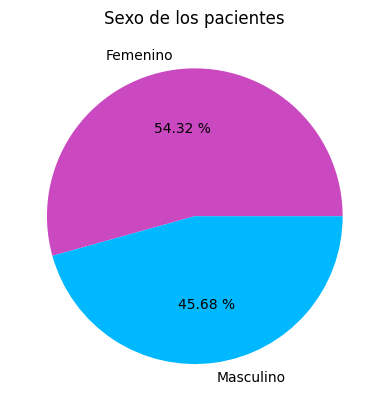

In [49]:
left = df[df['SEXO'] == 'F'].count()[0]
right = df[df['SEXO'] == 'M'].count()[0]

labels = ['Femenino', 'Masculino']
colors = ['#ca48c0','#00b8ff']
plt.pie([left,right], labels = labels, colors=colors, autopct='%.2f %%')
plt.title('Sexo de los pacientes')
plt.show()

**Fuente o tipo de contagio**

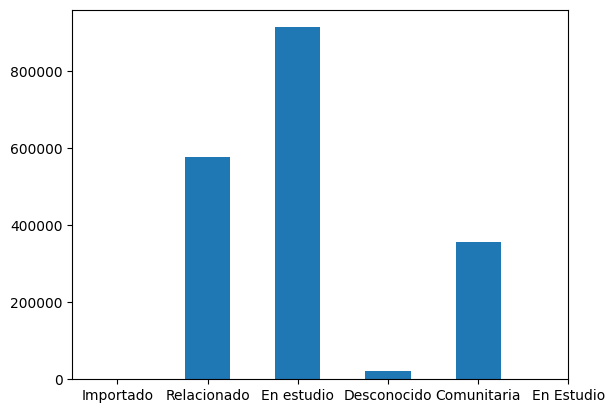

In [50]:
plt.hist(df['FUENTE_O_TIPO_DE_CONTAGIO'],align='left')
plt.show()

In [51]:
df

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado
...,...,...,...,...,...,...,...,...,...
1876292,1876293,2023-03-25,Sin dato,Sin dato,34,F,Comunitaria,Casa,Leve
1876293,1876294,2023-03-25,Sin dato,Sin dato,58,F,Comunitaria,Casa,Leve
1876294,1876295,2023-03-25,Sin dato,Sin dato,82,F,Comunitaria,Casa,Leve
1876295,1876296,2023-03-25,Sin dato,Sin dato,58,F,Comunitaria,Casa,Leve


# Handling Categorical Variables

Vamos a implementar one hot encoding en algunas variables categoricas para poder hacer diferentes analisis y eventualmente aplicar machine learning donde requerimos variables numericas

Se debe tener cuidado al momento de elegir el tipo de codificación, no sería correcto asignar label encoding a variables que no son ordinales, es decir que no hay orden entre ellas, para ese proposito es mejor usar one hot encoding

**Sex Encoding**

In [52]:
df['SEXO'].unique()

array(['F', 'M'], dtype=object)

In [53]:
dummies_sex = pd.get_dummies(df['SEXO'])

In [54]:
merged = pd.concat([df,dummies_sex],axis='columns')

In [55]:
merged.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
0,1,2020-03-06,Bogotá,Usaquén,19,F,Importado,Casa,Recuperado,1,0
1,2,2020-03-10,Bogotá,Engativá,22,F,Importado,Casa,Recuperado,1,0
2,3,2020-03-10,Bogotá,Engativá,28,F,Importado,Casa,Recuperado,1,0
3,4,2020-03-12,Bogotá,Fontibón,36,F,Importado,Casa,Recuperado,1,0
4,5,2020-03-12,Bogotá,Kennedy,42,F,Importado,Casa,Recuperado,1,0


In [56]:
df_ohe_sex = merged.drop(['SEXO'],axis=1) 

In [57]:
df_ohe_sex.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
0,1,2020-03-06,Bogotá,Usaquén,19,Importado,Casa,Recuperado,1,0
1,2,2020-03-10,Bogotá,Engativá,22,Importado,Casa,Recuperado,1,0
2,3,2020-03-10,Bogotá,Engativá,28,Importado,Casa,Recuperado,1,0
3,4,2020-03-12,Bogotá,Fontibón,36,Importado,Casa,Recuperado,1,0
4,5,2020-03-12,Bogotá,Kennedy,42,Importado,Casa,Recuperado,1,0


In [58]:
df_ohe_sex.shape

(1873785, 10)

**Estado Encoding**

En este caso si podemos ver evidenciar una jerarquía entre los valores de la variable estado. Siendo 0 El estado recuperado, y fallecido 4, en el casi de Fallecido (No aplica No causa directa) estuve buscando una descripción más detallada pero no fue posible encontrar ninguna información. 

Podría inferir que el paciente ya tenia una enfermedad o simplemente murio por otra razón mientras tenía COVID. Sin embargo desde mi punto de vista no es posible establecer una jerarquía con respecto a esta variable por lo cual la vamos a descartar.

In [59]:
df_ohe_sex['ESTADO'].unique()

array(['Recuperado', 'Fallecido',
       'Fallecido (No aplica No causa Directa)', 'Moderado', 'Grave',
       'Leve'], dtype=object)

**Análisis casos con Fallecido (No aplica No causa Directa)** 

La ubicación en este caso no aparece puesto que el paciente ha fallecido

In [60]:
df_ohe_sex[df_ohe_sex['ESTADO'] == 'Fallecido (No aplica No causa Directa)'].head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
330,331,2020-03-28,Bogotá,Teusaquillo,84,Relacionado,Fallecido (No aplica No causa Directa),Fallecido (No aplica No causa Directa),0,1
887,888,2020-04-07,Bogotá,Kennedy,26,Relacionado,Fallecido (No aplica No causa Directa),Fallecido (No aplica No causa Directa),0,1
1066,1067,2020-04-08,Bogotá,Suba,44,En estudio,Fallecido (No aplica No causa Directa),Fallecido (No aplica No causa Directa),1,0
1220,1221,2020-04-13,Bogotá,Kennedy,70,En estudio,Fallecido (No aplica No causa Directa),Fallecido (No aplica No causa Directa),0,1
1273,1274,2020-04-13,Bogotá,Barrios Unidos,77,En estudio,Fallecido (No aplica No causa Directa),Fallecido (No aplica No causa Directa),0,1


In [61]:
df_ohe_sex[df_ohe_sex['ESTADO'] == 'Fallecido (No aplica No causa Directa)'].shape

(8369, 10)

In [62]:
perc_descarte = df_ohe_sex[df_ohe_sex['ESTADO'] == 'Fallecido (No aplica No causa Directa)'].shape[0]/df_ohe_sex.shape[0]

In [63]:
print(f'Porcentaje de los datos que vamos a descartar: {perc_descarte*100}%')

Porcentaje de los datos que vamos a descartar: 0.446636086850946%


In [64]:
df_wo_fncd = df_ohe_sex[df_ohe_sex['ESTADO'] != 'Fallecido (No aplica No causa Directa)']

In [65]:
df_wo_fncd.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
0,1,2020-03-06,Bogotá,Usaquén,19,Importado,Casa,Recuperado,1,0
1,2,2020-03-10,Bogotá,Engativá,22,Importado,Casa,Recuperado,1,0
2,3,2020-03-10,Bogotá,Engativá,28,Importado,Casa,Recuperado,1,0
3,4,2020-03-12,Bogotá,Fontibón,36,Importado,Casa,Recuperado,1,0
4,5,2020-03-12,Bogotá,Kennedy,42,Importado,Casa,Recuperado,1,0


In [66]:
df_wo_fncd['ESTADO'].value_counts()

Recuperado    1835762
Fallecido       29449
Leve              126
Moderado           70
Grave               9
Name: ESTADO, dtype: int64

In [67]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder() 
#le.fit(["Fallecido","Grave","Moderado","Leve","Recuperado"])
#estado_le = le.transform(df_wo_fncd['ESTADO'])

In [68]:
df_wo_fncd['ESTADO'].unique()

array(['Recuperado', 'Fallecido', 'Moderado', 'Grave', 'Leve'],
      dtype=object)

In [69]:
df_wo_fncd['ESTADO']

0          Recuperado
1          Recuperado
2          Recuperado
3          Recuperado
4          Recuperado
              ...    
1876292          Leve
1876293          Leve
1876294          Leve
1876295          Leve
1876296          Leve
Name: ESTADO, Length: 1865416, dtype: object

In [70]:
df_wo_fncd

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
0,1,2020-03-06,Bogotá,Usaquén,19,Importado,Casa,Recuperado,1,0
1,2,2020-03-10,Bogotá,Engativá,22,Importado,Casa,Recuperado,1,0
2,3,2020-03-10,Bogotá,Engativá,28,Importado,Casa,Recuperado,1,0
3,4,2020-03-12,Bogotá,Fontibón,36,Importado,Casa,Recuperado,1,0
4,5,2020-03-12,Bogotá,Kennedy,42,Importado,Casa,Recuperado,1,0
...,...,...,...,...,...,...,...,...,...,...
1876292,1876293,2023-03-25,Sin dato,Sin dato,34,Comunitaria,Casa,Leve,1,0
1876293,1876294,2023-03-25,Sin dato,Sin dato,58,Comunitaria,Casa,Leve,1,0
1876294,1876295,2023-03-25,Sin dato,Sin dato,82,Comunitaria,Casa,Leve,1,0
1876295,1876296,2023-03-25,Sin dato,Sin dato,58,Comunitaria,Casa,Leve,1,0


In [71]:
label_encoder = {"Fallecido":4,"Grave":3,"Moderado":2,"Leve":1,"Recuperado":0}
df_wo_fncd['ESTADO'] = df_wo_fncd['ESTADO'].map(label_encoder) 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7848\3170298549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wo_fncd['ESTADO'] = df_wo_fncd['ESTADO'].map(label_encoder)


In [72]:
df_wo_fncd.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO,F,M
0,1,2020-03-06,Bogotá,Usaquén,19,Importado,Casa,0,1,0
1,2,2020-03-10,Bogotá,Engativá,22,Importado,Casa,0,1,0
2,3,2020-03-10,Bogotá,Engativá,28,Importado,Casa,0,1,0
3,4,2020-03-12,Bogotá,Fontibón,36,Importado,Casa,0,1,0
4,5,2020-03-12,Bogotá,Kennedy,42,Importado,Casa,0,1,0


In [73]:
df_wo_fncd['ESTADO'].unique()

array([0, 4, 2, 3, 1], dtype=int64)

Confirmamos que los valores se mantengan

In [74]:
df_wo_fncd['ESTADO'].value_counts()

0    1835762
4      29449
1        126
2         70
3          9
Name: ESTADO, dtype: int64

In [75]:
df_wo_fncd.corr()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7848\198326214.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_wo_fncd.corr()


,CASO,EDAD,ESTADO,F,M
CASO,1.000000,0.020823,-0.050126,0.034928,-0.034928
EDAD,0.020823,1.000000,0.203166,0.024555,-0.024555
ESTADO,-0.050126,0.203166,1.000000,-0.043850,0.043850
F,0.034928,0.024555,-0.043850,1.000000,-1.000000
M,-0.034928,-0.024555,0.043850,-1.000000,1.000000


A partir de la matriz de correlación podemos deducir que ninguna de las variables se correlaciona de forma significatica, la unica relación medianamente considerable es la de **Edad - Estado**, lo cual tiene bastante sentido, sin embargo la correlación es de unicamente 0.2.

In [76]:
df_num = df_wo_fncd

# Comprensión de los datos

In [77]:
df_num.describe()

,CASO,EDAD,ESTADO,F,M
count,1.865416e+06,1.865416e+06,1.865416e+06,1.865416e+06,1.865416e+06
mean,9.376209e+05,3.897038e+01,6.330438e-02,5.435635e-01,4.564365e-01
std,5.409235e+05,1.806105e+01,4.988416e-01,4.980987e-01,4.980987e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.692658e+05,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.378565e+05,3.700000e+01,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.405520e+06,5.100000e+01,0.000000e+00,1.000000e+00,1.000000e+00
max,1.876297e+06,9.300000e+01,4.000000e+00,1.000000e+00,1.000000e+00


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7848\2091809964.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_num.corr()


<Axes: >

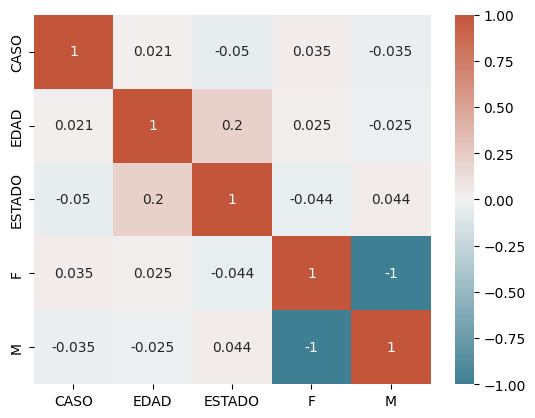

In [78]:
corr = df_num.corr()
sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, annot=True, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))

# Relación entre la edad y estado promedio

In [79]:
edad_estados = df_num.groupby(['EDAD'])['ESTADO'].mean()
edad_estados

EDAD
0     0.013630
1     0.003184
2     0.004008
3     0.002228
4     0.002230
        ...   
89    0.955582
90    1.097911
91    1.157212
92    1.062271
93    1.274376
Name: ESTADO, Length: 94, dtype: float64

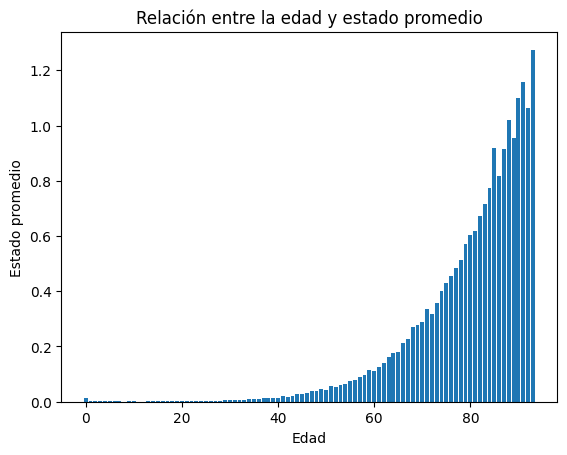

In [80]:
fig, ax = plt.subplots()
plt.xlabel('Edad')
plt.ylabel('Estado promedio')
plt.title('Relación entre la edad y estado promedio')
plt.bar(edad_estados.index,edad_estados)
plt.show()

Podemos corroborar que entre mayor sea la edad, más probable es que el estado del paciente sea grave (0 es recuperado y 4 fallecido), aunque no hay una diferencia abismal, puesto que el estado promedio de edades de 80+ es aproximadamente 1.2

# Kurtosis and Skewness

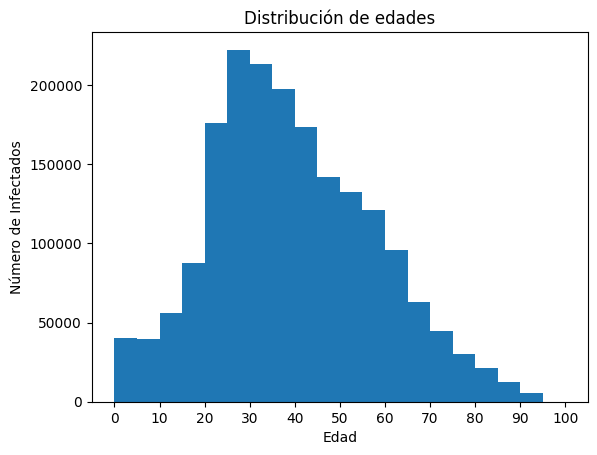

In [88]:
bins = np.arange(0,105, 5)
bins
fig, ax = plt.subplots()
ax.hist(df['EDAD'], bins=bins)

# set the x and y axis tick marks
ax.set_xticks(np.arange(0,105, 10))

ax.set_xlabel('Edad')
ax.set_ylabel('Número de Infectados')
ax.set_title('Distribución de edades')

plt.show()

In [89]:
df.EDAD.mean()

39.09705222317395

In [90]:
df.EDAD.std()

18.164253756564417

In [85]:
df.EDAD.skew()

0.33782782343179396

In [86]:
df.EDAD.kurtosis()

-0.24260596355821606

Apartir de los datos de skewness y kurtosis podemos deducir:

* Al tener un skewness > 0, y viendo la grafica, podemos ver una asimetría, la distribución se alarga más hacia la derecha, es de cir las edades mayores, sin embargo vemos una densidad mucho mayor desde los 40 hacia atras
* Tambien podemos evidenciar una kurtosis < 0, lo cual indica que hay baja presencia de outliers, con edades variando entre los 0 y 90 aos principalmente